## Xg Preidction

* time series factor: the period of game, weekend or weekday, season
* team stats: rank, total goals till now per game, shot per game until now, total xg per game
* oppo stats: rank, total goals, total xG, total shot, history shot/xg/gaol per game
* Player stats: 
* Recent performence: recent xG, recent goal, recent shot


# Load package and data


In [87]:
import pandas as pd
import numpy as np
import datetime
import warnings
warnings.filterwarnings('ignore')

In [88]:
df = pd.read_csv('/Users/marceloyou/Desktop/Xg-Prediction/data/matchdata/2015-2022matchdata(modified).csv', index_col=[0])
df.head()

,Season,id,datetime,result,team,team_xG,team_score,team_conced,home,opponent,...,team_stage,oppo_stage,y,oppo_draw_rate,team_accumalated_points,team_points_pergame,oppo_accumalated_points,oppo_points_pergame,team_recent_points,oppo_recent_points
0,2015-2016,81,2015-08-08 15:45:00,w,Manchester United,0.627539,1,0,0,Tottenham,...,0,0,1,0.500000,5.0,1.250000,5.0,1.250000,6.000,6.000
1,2015-2016,84,2015-08-08 18:00:00,w,Leicester,2.568030,4,2,0,Sunderland,...,0,0,1,1.000000,2.0,1.000000,2.0,1.000000,7.000,3.000
2,2015-2016,85,2015-08-08 18:00:00,l,Norwich,1.130760,1,3,0,Crystal Palace,...,0,0,0,0.500000,4.0,2.000000,1.0,0.500000,2.892,7.000
3,2015-2016,83,2015-08-08 18:00:00,d,Everton,0.604226,2,2,0,Watford,...,0,0,0,0.218750,86.0,1.720000,49.0,1.531250,3.000,2.892
4,2015-2016,82,2015-08-08 18:00:00,l,Bournemouth,0.876106,0,1,0,Aston Villa,...,0,0,0,0.193548,44.0,1.466667,39.0,1.258065,2.892,3.000


In [89]:
df.columns

Index(['Season', 'id', 'datetime', 'result', 'team', 'team_xG', 'team_score',
       'team_conced', 'home', 'opponent', 'oppo_xG', 'oppo_score',
       'oppo_conced', 'oppo_home', 'team_shot_attempt', 'oppo_shot_attempt',
       'team_rank', 'oppo_rank', 'team_win_rate', 'oppo_win_rate',
       'team_recent_goals', 'team_recent_conced', 'team_recent_state',
       'team_recent_xG', 'oppo_recent_goals', 'oppo_recent_conced',
       'oppo_recent_state', 'oppo_recent_xG', 'team_stage', 'oppo_stage', 'y',
       'oppo_draw_rate', 'team_accumalated_points', 'team_points_pergame',
       'oppo_accumalated_points', 'oppo_points_pergame', 'team_recent_points',
       'oppo_recent_points'],
      dtype='object')

## Utils function

In [90]:
def select_team_data(data, team, season = None):
    if season:
        return data.loc[(data['Season'] == f'{season}-{season+1}') &((data['opponent'] == team) | (data['team'] == team))]
    else:
        return data.loc[(data['opponent'] == team) | (data['team'] == team)]

def minus_one_day(dt, return_str = True):
    date = datetime.datetime.strptime(dt, '%Y-%m-%d') - datetime.timedelta(days = 1)
    return datetime.datetime.strftime(date,"%Y-%m-%d") if return_str else date

# Create more features

## Feature Utils function

In [91]:
def transform_stats(df, team):
    df['goals'] = df.apply(lambda x: x['team_score'] if x['team'] == team else x['oppo_score'], axis = 1)
    df['shots'] = df.apply(lambda x: x['team_shot_attempt'] if x['team'] == team else x['oppo_shot_attempt'], axis = 1)
    df['xg'] = df.apply(lambda x: x['team_xG'] if x['team'] == team else x['oppo_xG'], axis = 1)
    df['conced'] = df.apply(lambda x: x['team_conced'] if x['team'] == team else x['oppo_conced'], axis = 1)
    df['team'] = team
    df = df[['Season', 'datetime', 'team', 'id', 'goals', 'shots','xg', 'conced']]
    return df



def cumsum_stats(df, team_stats, team):
    df['cumsum_goals'] = np.append(team_stats.loc[team, 'goals'], np.cumsum(df['goals'].values)[:-1])
    df['cumsum_shots'] = np.append(team_stats.loc[team, 'shots'], np.cumsum(df['shots'].values)[:-1])
    df['cumsum_xg'] = np.append(team_stats.loc[team, 'xg'], np.cumsum(df['xg'].values)[:-1])
    df['cumsum_conced'] = np.append(team_stats.loc[team, 'conced'], np.cumsum(df['conced'].values)[:-1])
    df.reset_index(inplace = True)

    def divide_index(x):
        return (x['cumsum_goals']/x.name, x['cumsum_shots']/x.name, x['cumsum_xg']/x.name, x['cumsum_conced']/x.name) if x.name != 0 else (x['cumsum_goals'],x['cumsum_shots'],x['cumsum_xg'],x['cumsum_conced'])
    df['cumsum_goal_pergame'],  df['cumsum_shot_pergame'],  df['cumsum_xg_pergame'],  df['cumsum_conced_pergame'] = zip(*df.apply(lambda x: divide_index(x), axis = 1))
    return df
    
def get_team_stats(df, team_list):
    # use to fill na in xgstats
    res = pd.DataFrame(columns=['goals', 'shots','xg', 'conced'])
    for team in team_list:
        team_df =  transform_stats(select_team_data(df, team), team)[['goals', 'shots','xg', 'conced']]
        team_df = team_df.mean(axis = 0).to_frame().transpose().set_index([[team]])
        res = pd.concat([res, team_df])
    return res




    
def get_team_xgstats(df, team_list, team_stats):
    res = pd.DataFrame(columns=['a'] * 17)
    for i, team in enumerate(team_list):
        team_df = pd.DataFrame(columns=['a'] * 17)
        year_list = list(map(lambda x: int(x.split('-')[0]),select_team_data(df, team)['Season'].unique().tolist()))
        for j, year in enumerate(year_list):
            year_df = select_team_data(df, team, season=year)
            xg_stats_df = cumsum_stats(transform_stats(year_df, team), team_stats, team)
            if j == 0:
                team_df.columns = xg_stats_df.columns
            xg_stats_df.set_index([[year] * xg_stats_df.shape[0]], inplace = True)
            team_df  = pd.concat([team_df,xg_stats_df])
        if i == 0:
            res.columns = team_df.columns
        res = pd.concat([res, team_df])
    return res
                



In [92]:
def table_to_dict(team, oppo, table):
    return {t: table.loc[table.index == t, 'goals'].values[0] for t in [team, oppo]}

def history_goals(row, fixture,team_stats):
   
   fixture['Date'] = pd.to_datetime(fixture['Date'])
   fixture_data = fixture.loc[fixture['Date'] < minus_one_day(str(row['datetime']).split(' ')[0], return_str=False)]
   match_patten = [' VS '.join([row['team'], row['opponent']]), ' VS '.join([row['opponent'], row['team']])]
   select_df = fixture_data.loc[fixture_data['MatchName'].isin(match_patten)]

   if select_df.shape[0] != 0:
        select_df['team_goals'] = select_df.apply(lambda x: x['Home_score'] if x['HomeTeam'] == row['team'] else x['Away_score'], axis = 1)
        select_df['oppo_goals'] = select_df.apply(lambda x: x['Home_score'] if x['HomeTeam'] == row['opponent'] else x['Away_score'], axis = 1)
        return select_df['team_goals'].sum(), select_df['oppo_goals'].sum()
   
   else:
      data_dict = table_to_dict(row['team'], row['opponent'], team_stats)
      return data_dict[row['team']], data_dict[row['opponent']]

    

In [93]:
def return_xg_from_table(xg_stats, id, team):
    res = xg_stats.loc[(xg_stats['id'] == id) & (xg_stats['team'] == team), ['cumsum_goals','cumsum_shots', 'cumsum_xg','cumsum_conced']].values.reshape(4,).tolist()
    return res[0], res[1],res[2], res[3]

def return_xg_pergame_from_table(xg_stats, id, team):
    res = xg_stats.loc[(xg_stats['id'] == id) & (xg_stats['team'] == team), ['cumsum_goal_pergame','cumsum_shot_pergame', 'cumsum_xg_pergame','cumsum_conced_pergame']].values.reshape(4,).tolist()
    return res[0], res[1], res[2], res[3]

def xg_data_pipeline(df, xg_stats, fixture, team_stats):
    
    # Time series related
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['month'] = df['datetime'].dt.month
    df['weekday'] = df['datetime'].apply(lambda x: 1 if x.weekday() in [5,6] else 0)
    df['game_period'] = df['datetime'].apply(lambda x: 'afternoon' if x.hour >= 12 and x.hour <= 17 else 'evening')
    
    # Team stats fature
    df['team_cumsum_goals'], df['team_cumsum_shots'], df['team_cumsum_xg'], df['team_cumsum_conced'] = zip(*df.apply(lambda x: return_xg_from_table(xg_stats, x['id'], x['team']), axis=1))
    df['team_cumsum_goal_pergame'],  df['team_cumsum_shot_pergame'],  df['team_cumsum_xg_pergame'],  df['team_cumsum_conced_pergame'] = zip(*df.apply(lambda x: return_xg_pergame_from_table(xg_stats, x['id'], x['team']), axis=1))

    # Oppo stats
    df['oppo_cumsum_goals'], df['oppo_cumsum_shots'], df['oppo_cumsum_xg'], df['oppo_cumsum_conced'] = zip(*df.apply(lambda x: return_xg_from_table(xg_stats, x['id'], x['opponent']), axis=1))
    df['oppo_cumsum_goal_pergame'],  df['oppo_cumsum_shot_pergame'],  df['oppo_cumsum_xg_pergame'],  df['oppo_cumsum_conced_pergame'] = zip(*df.apply(lambda x: return_xg_pergame_from_table(xg_stats, x['id'], x['opponent']), axis=1))

    
    df['team_history_goals'], df['oppo_history_goals'] = zip(*df.apply(lambda x: history_goals(x, fixture, team_stats), axis=1))

    return df






## Feature main fucntion

In [94]:
#Get team stats
team_list = df['team'].unique().tolist()
team_stats = get_team_stats(df, team_list)

In [95]:
xg_stats = get_team_xgstats(df, team_list, team_stats=team_stats)

In [96]:
fixture = pd.read_csv('/Users/marceloyou/Desktop/Xg-Prediction/data/fixtures/20132023fixtures_result.csv', index_col=[0])
fixture['MatchName'] = fixture[['HomeTeam', 'AwayTeam']].agg(' VS '.join, axis = 1)
fixture.head()

,Date,HomeTeam,AwayTeam,Home_score,Away_score,Result,MatchName
Season,,,,,,,
2013-2014,2013-08-17,Arsenal,Aston Villa,1.0,3.0,A,Arsenal VS Aston Villa
2013-2014,2013-08-17,Liverpool,Stoke,1.0,0.0,H,Liverpool VS Stoke
2013-2014,2013-08-17,Norwich,Everton,2.0,2.0,D,Norwich VS Everton
2013-2014,2013-08-17,Sunderland,Fulham,0.0,1.0,A,Sunderland VS Fulham
2013-2014,2013-08-17,Swansea,Manchester United,1.0,4.0,A,Swansea VS Manchester United


In [97]:
data = df[['Season', 'id', 'datetime', 'team', 'opponent', 'home', 'oppo_home', \
            'team_recent_goals', 'team_recent_conced', 'team_recent_xG','oppo_recent_goals', 'oppo_recent_conced', \
                'oppo_recent_xG', 'team_stage', 'team_rank', 'oppo_rank', 'team_xG', 'oppo_xG']]

In [98]:
data = xg_data_pipeline(data, xg_stats, fixture, team_stats)

KeyboardInterrupt: 

In [ ]:
data.to_csv('/Users/marceloyou/Desktop/Xg-Prediction/data/xG/2015-2022xgdata.csv', index = None)

In [ ]:
data = pd.read_csv('/Users/marceloyou/Desktop/Xg-Prediction/data/xG/2015-2022xgdata.csv')
data.head()

,Season,id,datetime,team,opponent,home,oppo_home,team_recent_goals,team_recent_conced,team_recent_xG,...,oppo_cumsum_goals,oppo_cumsum_shots,oppo_cumsum_xg,oppo_cumsum_conced,oppo_cumsum_goal_pergame,oppo_cumsum_shot_pergame,oppo_cumsum_xg_pergame,oppo_cumsum_conced_pergame,team_history_goals,oppo_history_goals
0,2015-2016,81,2015-08-08 15:45:00,Manchester United,Tottenham,0,1,1.631579,0.973684,1.426579,...,1.868327,14.590747,1.650819,1.028470,1.868327,14.590747,1.650819,1.028470,6.000000,4.000000
1,2015-2016,84,2015-08-08 18:00:00,Leicester,Sunderland,0,1,1.210526,1.447368,1.268684,...,1.013158,10.907895,0.983432,1.723684,1.013158,10.907895,0.983432,1.723684,0.000000,0.000000
2,2015-2016,85,2015-08-08 18:00:00,Norwich,Crystal Palace,0,1,0.910000,1.530000,0.998000,...,1.150000,11.346429,1.175635,1.435714,1.150000,11.346429,1.175635,1.435714,2.000000,1.000000
3,2015-2016,83,2015-08-08 18:00:00,Everton,Watford,0,1,1.263158,1.315789,1.181316,...,1.078947,11.285088,1.162010,1.675439,1.078947,11.285088,1.162010,1.675439,1.295374,1.078947
4,2015-2016,82,2015-08-08 18:00:00,Bournemouth,Aston Villa,0,1,0.910000,1.530000,0.998000,...,1.143713,11.958084,1.130635,1.586826,1.143713,11.958084,1.130635,1.586826,1.263415,1.143713


# Transform match data to specific team format

## Data Transformation Utils function

In [ ]:
def transform_to_xG(data, team):
    df = select_team_data(data, team)
    df.reset_index(inplace = True)
    for i in range(df.shape[0]):
        if df.loc[i, 'team'] == team:
             pass
        else:
            df.loc[i, ['team_recent_goals', 'team_recent_xG']], df.loc[i, 'oppo_recent_conced'] = df.loc[i, ['oppo_recent_goals', 'oppo_recent_xG']].values,df.loc[i, 'team_recent_conced']
            df.loc[i, ['home', 'team_rank']],df.loc[i, ['oppo_home', 'oppo_rank']] = df.loc[i, ['oppo_home', 'oppo_rank']].values, df.loc[i, ['home', 'team_rank']].values
            df.loc[i, 'team'], df.loc[i, 'opponent'] = df.loc[i, 'opponent'], df.loc[i, 'team']
            df.loc[i, ['team_cumsum_goals', 'team_cumsum_shots','team_cumsum_xg']], df.loc[i, 'oppo_cumsum_conced'] = df.loc[i, ['oppo_cumsum_goals', 'oppo_cumsum_shots','oppo_cumsum_xg']].values, df.loc[i, 'team_cumsum_conced']
            df.loc[i, ['team_cumsum_goal_pergame', 'team_cumsum_shot_pergame','team_cumsum_xg_pergame']], df.loc[i, 'oppo_cumsum_conced_pergame'] = df.loc[i, ['oppo_cumsum_goal_pergame', 'oppo_cumsum_shot_pergame','oppo_cumsum_xg_pergame']].values, df.loc[i, 'team_cumsum_conced_pergame']
            df.loc[i, 'team_history_goals'] = df.loc[i, 'oppo_history_goals']
            df.loc[i, 'team_xG'], df.loc[i, 'oppo_xG'] = df.loc[i, 'oppo_xG'], df.loc[i, 'team_xG']
    df = df[['Season', 'datetime','id', 'team', 'opponent', 'home','team_recent_goals', 'team_recent_xG','oppo_recent_conced', \
            'team_stage', 'team_rank', 'oppo_rank', 'month', 'weekday','game_period', \
            'team_cumsum_goals', 'team_cumsum_shots','team_cumsum_xg', 'team_cumsum_goal_pergame', 'team_cumsum_shot_pergame','team_cumsum_xg_pergame', \
                'oppo_cumsum_conced', 'oppo_cumsum_conced_pergame', 'team_history_goals', 'team_xG']]
    return df



In [ ]:
arsenal = transform_to_xG(data, 'Arsenal')

In [188]:
arsenal_data = arsenal.drop(columns=['datetime', 'id', 'team'])

# Model Exploration

## Encode category varible

In [168]:
from sklearn.preprocessing import LabelEncoder
def encode_coulumns(df, col_list):
    le = LabelEncoder()
    for col in col_list:
        df[col] = le.fit_transform(df[col])
    return df 

def change_col_category(df, col_list):
    for col in col_list:
        df[col] = df[col].astype('category')
    return df

arsenal_data = encode_coulumns(arsenal_data, ['Season', 'opponent', 'game_period'])


## Model Construction

In [ ]:
!pip install xgboost
!pip install lightgbm
!brew install libomp


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [146]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV

In [169]:
train_arsenal = arsenal_data.iloc[:-5]
train_x, train_y = train_arsenal.drop(columns=['team_xG']), train_arsenal['team_xG']
test_arsenal = arsenal_data.iloc[-5:]
test_x, test_y = test_arsenal.drop(columns=['team_xG']), test_arsenal['team_xG']

In [170]:
train_x_category, test_x_category = change_col_category(train_x, ['Season', 'opponent', 'game_period']), change_col_category(test_x, ['Season', 'opponent', 'game_period'])

In [171]:
train_x_category.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275 entries, 0 to 274
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   Season                      275 non-null    category
 1   opponent                    275 non-null    category
 2   home                        275 non-null    int64   
 3   team_recent_goals           275 non-null    float64 
 4   team_recent_xG              275 non-null    float64 
 5   oppo_recent_conced          275 non-null    float64 
 6   team_stage                  275 non-null    int64   
 7   team_rank                   275 non-null    int64   
 8   oppo_rank                   275 non-null    int64   
 9   month                       275 non-null    int64   
 10  weekday                     275 non-null    int64   
 11  game_period                 275 non-null    category
 12  team_cumsum_goals           275 non-null    float64 
 13  team_cumsum_shots   

## Xgboost 

In [140]:
xgboost = xgb.XGBRegressor(
    learning_rate = 0.01
)
xgboost.fit(train_x, train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [141]:
predict_y = xgboost.predict(test_x)

In [142]:
print(f'The MAE: {mean_absolute_error(test_y, predict_y)} \n The MSE: {mean_squared_error(test_y, predict_y)}')

The MAE: 1.0967749399848938 
 The MSE: 1.3344562512563525


In [143]:
predict_y

array([1.8280721, 0.8725536, 1.4151794, 0.9338425, 1.5452449],
      dtype=float32)

In [145]:
arsenal.tail()

,Season,datetime,id,team,opponent,home,team_recent_goals,team_recent_xG,oppo_recent_conced,team_stage,...,team_cumsum_goals,team_cumsum_shots,team_cumsum_xg,team_cumsum_goal_pergame,team_cumsum_shot_pergame,team_cumsum_xg_pergame,oppo_cumsum_conced,oppo_cumsum_conced_pergame,team_history_goals,team_xG
275,2022,2022-10-16 13:00:00,18305,Arsenal,Leeds,1,2.4,2.169202,1.8,0,...,23.0,150.0,19.477800,2.555556,16.666667,2.164200,12.0,1.500000,10.000000,0.821757
276,2022,2022-10-23 13:00:00,18328,Arsenal,Southampton,1,2.2,1.773611,1.6,0,...,24.0,159.0,20.299557,2.400000,15.900000,2.029956,18.0,1.636364,28.000000,1.578970
277,2022,2022-10-30 14:00:00,18332,Arsenal,Nottingham Forest,0,2.2,1.804929,1.2,0,...,25.0,171.0,21.878527,2.272727,15.545455,1.988957,23.0,1.916667,1.764286,3.006990
278,2022,2022-11-06 12:00:00,18343,Arsenal,Chelsea,1,2.6,2.142285,1.0,0,...,30.0,195.0,24.885517,2.500000,16.250000,2.073793,15.0,1.250000,21.000000,2.378460
279,2022,2022-11-12 19:45:00,18361,Arsenal,Wolverhampton Wanderers,1,2.2,2.121171,2.0,0,...,31.0,209.0,27.263977,2.384615,16.076923,2.097229,22.0,1.571429,10.000000,2.279960


## Xgboost parameter tuning

In [150]:
params = {
    'max_depth' :[4, 8, 12],
    'learning_rate': [0.1, 0.001, 0.0001],
    'n_estimators': [100,500,1000],
    'subsample': [0.4, 0.9]
}

xbgr = xgb.XGBRegressor(seed = 20)

clf = GridSearchCV(estimator=xbgr,
                param_grid=params, 
                scoring='neg_mean_absolute_error',
                verbose=1)

clf.fit(train_x, train_y)

print(f'Best parameters: {clf.best_params_} \n Best Score: {clf.best_score_}')

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters: {'learning_rate': 0.001, 'max_depth': 4, 'n_estimators': 1000, 'subsample': 0.4} 
 Best Score: -0.7657612465600863


In [149]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

# LightGBM

In [152]:
lgbm_train_data = lgb.Dataset(train_x, label = train_y)


In [155]:
lgbm = lgb.LGBMRegressor()
lgbm.fit(train_x, train_y)

LGBMRegressor()

In [156]:
predict_y = lgbm.predict(test_x)

In [157]:
print(f'The MAE: {mean_absolute_error(test_y, predict_y)} \n The MSE: {mean_squared_error(test_y, predict_y)}')

The MAE: 0.8305496097562951 
 The MSE: 1.0519842861741322


In [158]:
params = {
    'max_depth' :[4, 8, 12],
    'learning_rate': [0.1, 0.001, 0.0001],
    'n_estimators': [100,500,1000],
    'num_leaves': [16,32,64,128,256]
}

lgtmbest = lgb.LGBMRegressor(seed = 20) 

clf = GridSearchCV(estimator=lgtmbest,
                param_grid=params, 
                scoring='neg_mean_absolute_error',
                verbose=1)

clf.fit(train_x, train_y)

print(f'Best parameters: {clf.best_params_} \n Best Score: {clf.best_score_}')

Fitting 5 folds for each of 135 candidates, totalling 675 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 100, 'num_leaves': 16} 
 Best Score: -0.7170969875919904


# Support Vector Regressor

In [177]:
from sklearn.svm import SVR
from sklearn.preprocessing import Normalizer, StandardScaler

svr = SVR()
normalizer = Normalizer()
sd = StandardScaler()

train_x_category_scale, test_x_category_scale = normalizer.fit_transform(train_x_category), normalizer.fit_transform(test_x_category)
svr.fit(train_x_category, train_y)

predict_y_svr = svr.predict(test_x_category)
print(f'The MAE: {mean_absolute_error(test_y, predict_y_svr)} \n The MSE: {mean_squared_error(test_y, predict_y_svr)}')

The MAE: 0.7001995172193329 
 The MSE: 0.6337516002582395


In [179]:
svm_params = {'kernel': ['linear', 'poly', 'rbf'], 
               'gamma': ['scale', 'auto'], 
               'C': [0.1, 1, 10]}

svmbest = SVR()
clf_svr = GridSearchCV(
    estimator=svmbest,
    param_grid=svm_params,
    scoring='neg_mean_absolute_error',
    verbose=2
)

clf_svr.fit(train_x_category, train_y)

print(f'Best parameters: {clf_svr.best_params_} \n Best Score: {clf_svr.best_score_}')

KeyboardInterrupt: 

# GAM

In [180]:
!pip install pygam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 2.5 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


Text(0.5, 1.0, 'Pair plot')

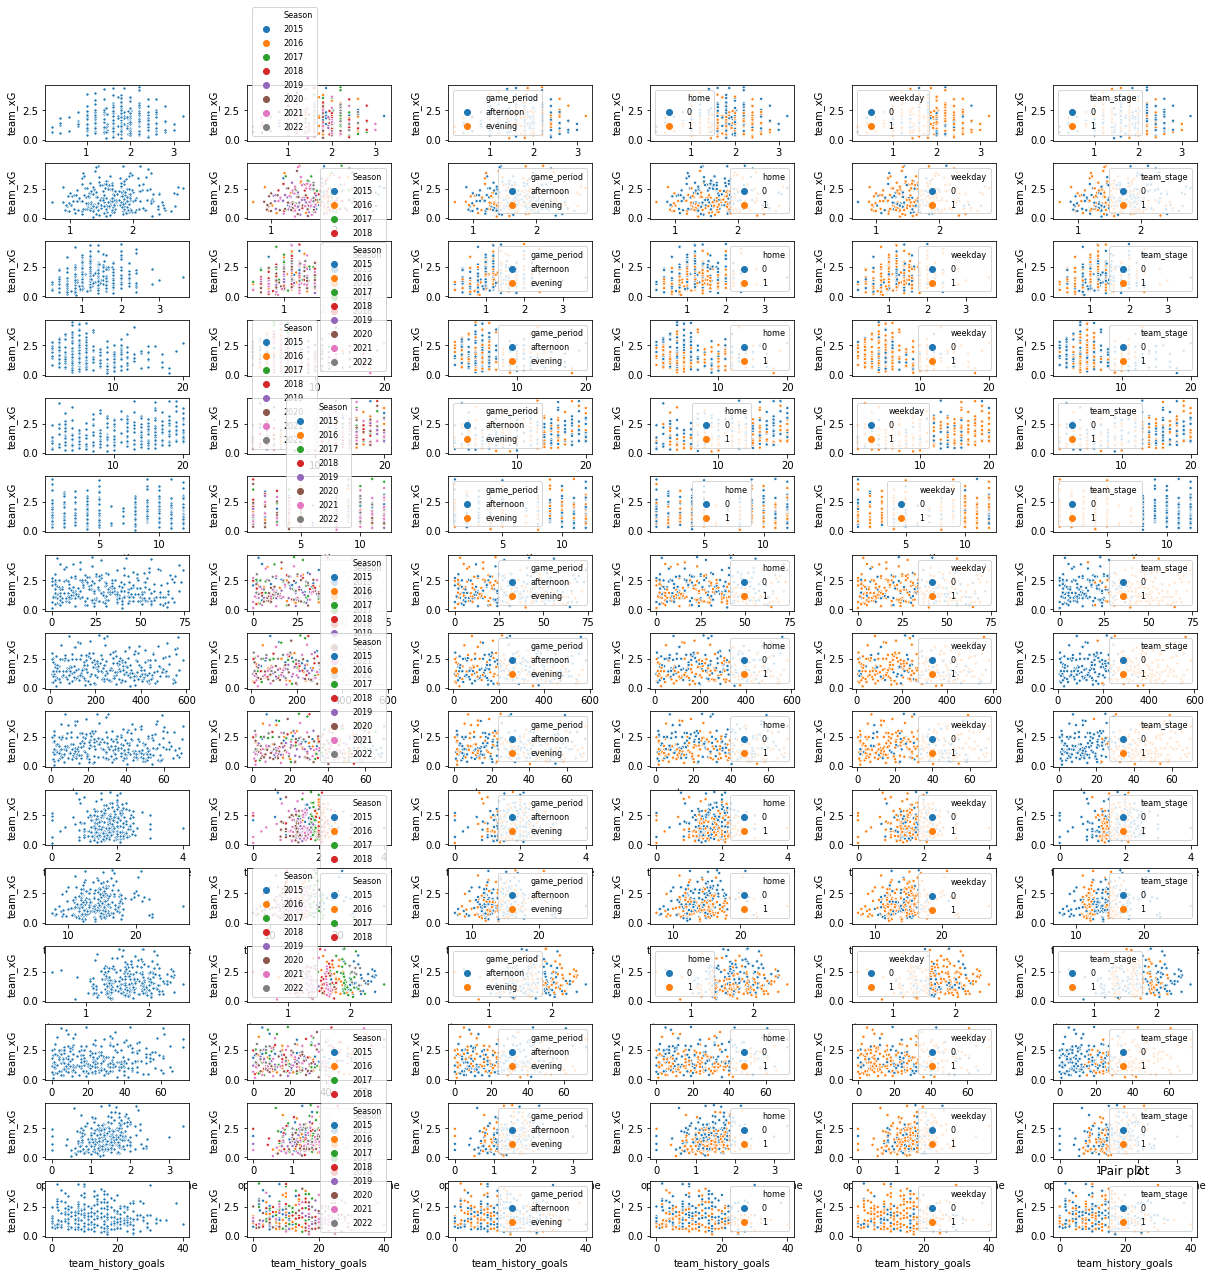

In [201]:
from statsmodels.gam.api import GLMGam, BSplines
import matplotlib.pyplot as plt
import seaborn as sns

category_var = ['Season', 'game_period', 'home', 'weekday', 'team_stage']
plot_arsenal = change_col_category(arsenal_data, category_var)

plt.figure(figsize = (20,20))
plt.title('Pair plot')
numeirc_feature = plot_arsenal.drop(columns = 'team_xG').select_dtypes(include = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns.tolist()
for i in range(len(numeirc_feature)):
    for j in range(len(category_var)+1):
        plt.subplot(15,6, i * 6 + (j+1))
        plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
        
        if j == 0:
            f1 = sns.scatterplot(data = plot_arsenal, x = numeirc_feature[i], y = 'team_xG', s = 10)
        else:
            f1 = sns.scatterplot(data = plot_arsenal, x = numeirc_feature[i], y = 'team_xG', hue = category_var[j-1], s= 10)
            plt.setp(f1.get_legend().get_texts(), fontsize = '8')
            plt.xlabel(numeirc_feature[i])
        


In [230]:
from pygam import LinearGAM, s, f

plot_arsenal = encode_coulumns(plot_arsenal, category_var + ['opponent'])

train_x_category, train_y = plot_arsenal.iloc[:-5].drop(columns = 'team_xG'),  plot_arsenal.iloc[:-5]['team_xG']
test_x_category, test_y = plot_arsenal.iloc[-5:].drop(columns = 'team_xG'), plot_arsenal.iloc[-5:]['team_xG']



In [222]:
spline_res = [ f's({i})' for i in range(len(train_x_category.columns.to_list())) if train_x_category.columns.to_list()[i] not in category_var + ['opponent']]
factor_res = [f'f({i})' for i in range(len(train_x_category.columns.to_list())) if train_x_category.columns.to_list()[i] in category_var + ['opponent']]

formula = ' + '.join(spline_res) + ' + ' + ' + '.join(factor_res)
formula

's(3) + s(4) + s(5) + s(7) + s(8) + s(9) + s(12) + s(13) + s(14) + s(15) + s(16) + s(17) + s(18) + s(19) + s(20) + f(0) + f(1) + f(2) + f(6) + f(10) + f(11)'

In [231]:
gam = LinearGAM(s(3) + s(4) + s(5) + s(7) + s(8) + s(9) + s(12) + s(13) + \
            s(14) + s(15) + s(16) + s(17) + s(18) + s(19) + s(20) + f(0) + \
                f(1) + f(2) + f(6) + f(10) + f(11)).fit(train_x_category, train_y)

In [233]:
predict_y_gam = gam.predict(test_x_category)
print(f'The MAE: {mean_absolute_error(test_y, predict_y_gam)} \n The MSE: {mean_squared_error(test_y, predict_y_gam)}')

The MAE: 0.7992321772697777 
 The MSE: 1.2830789350588323


# TIme series model

In [236]:
import datetime
arsenal['datetime'] = pd.to_datetime(arsenal['datetime'])
time_arsenal = arsenal
time_arsenal['datetime'] = arsenal['datetime'].dt.strftime('%Y-%m-%d')

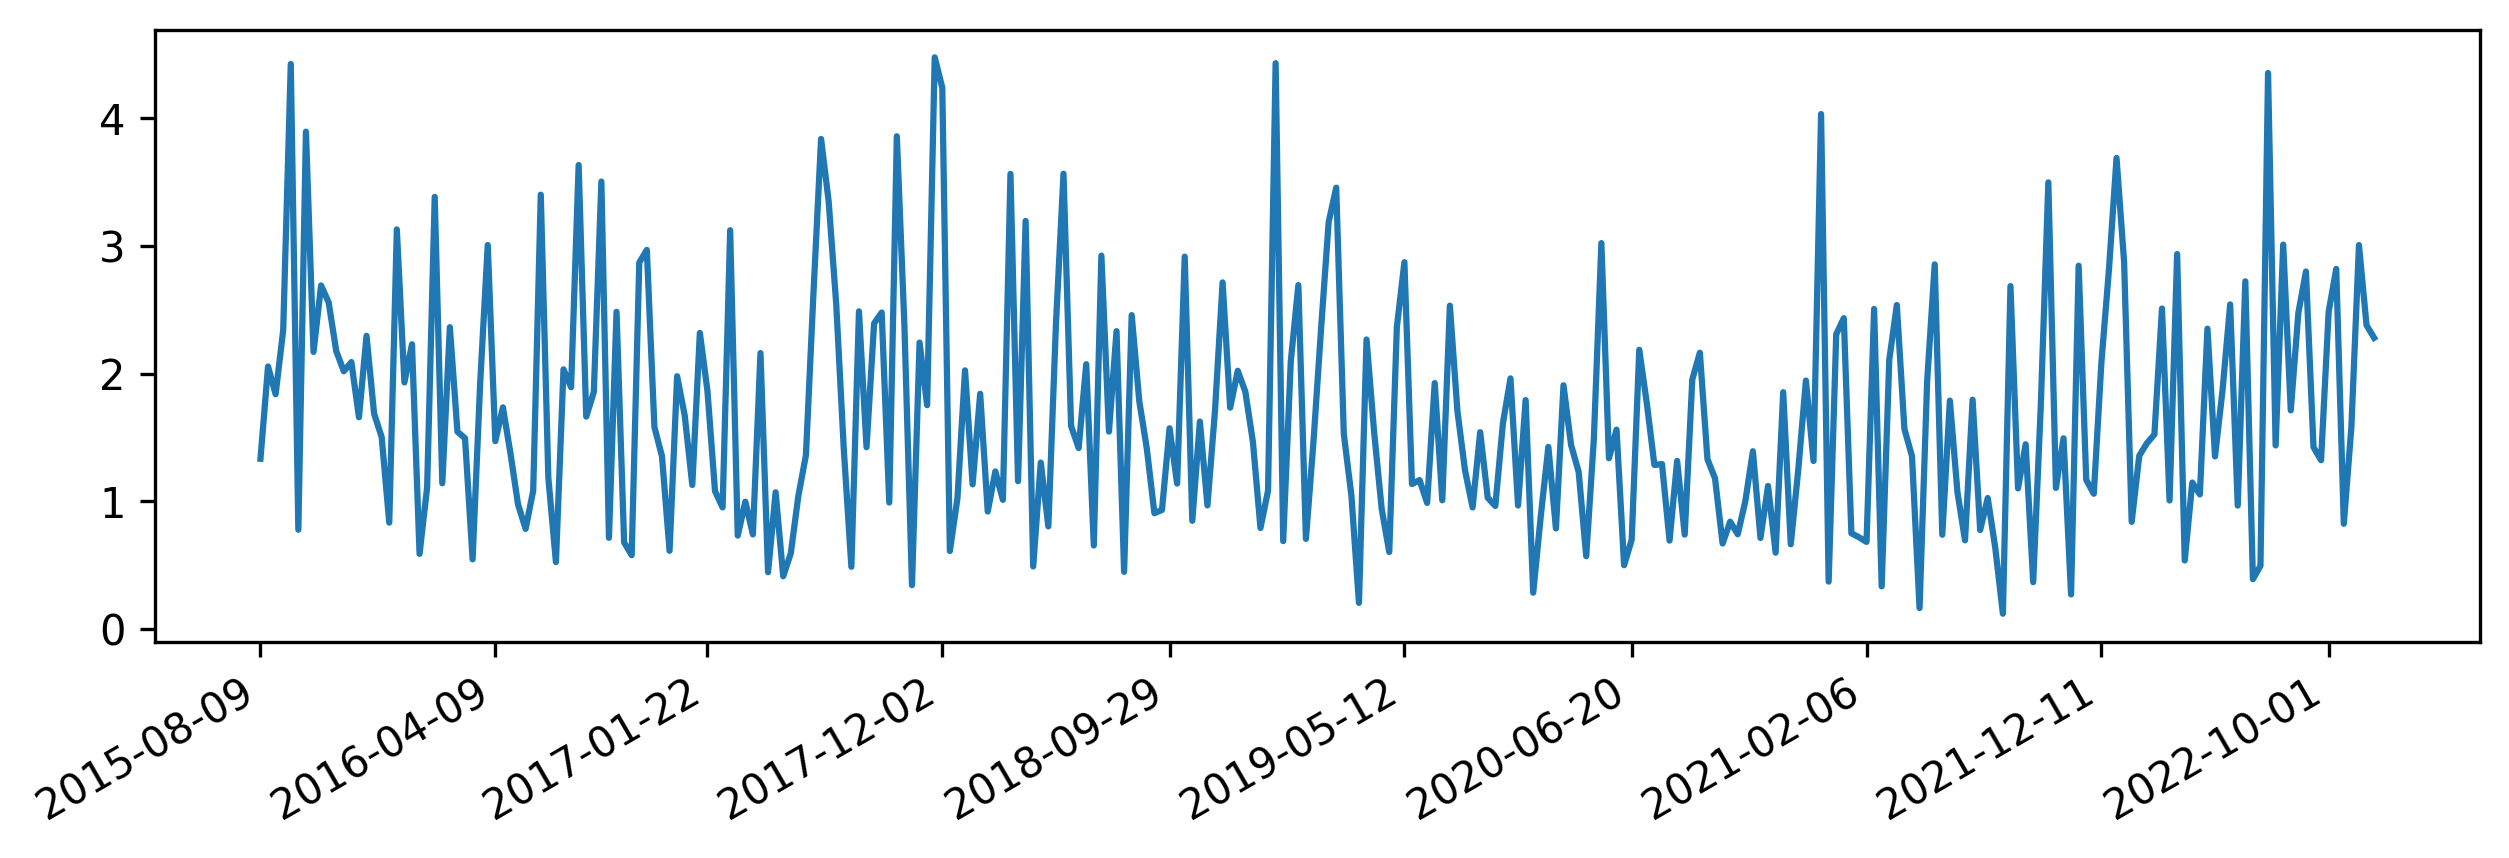

In [250]:
import matplotlib.dates as mdates
fig = plt.figure(figsize = (10, 3), dpi = 300)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.plot(time_arsenal['datetime'], time_arsenal['team_xG'])
plt.gcf().autofmt_xdate()



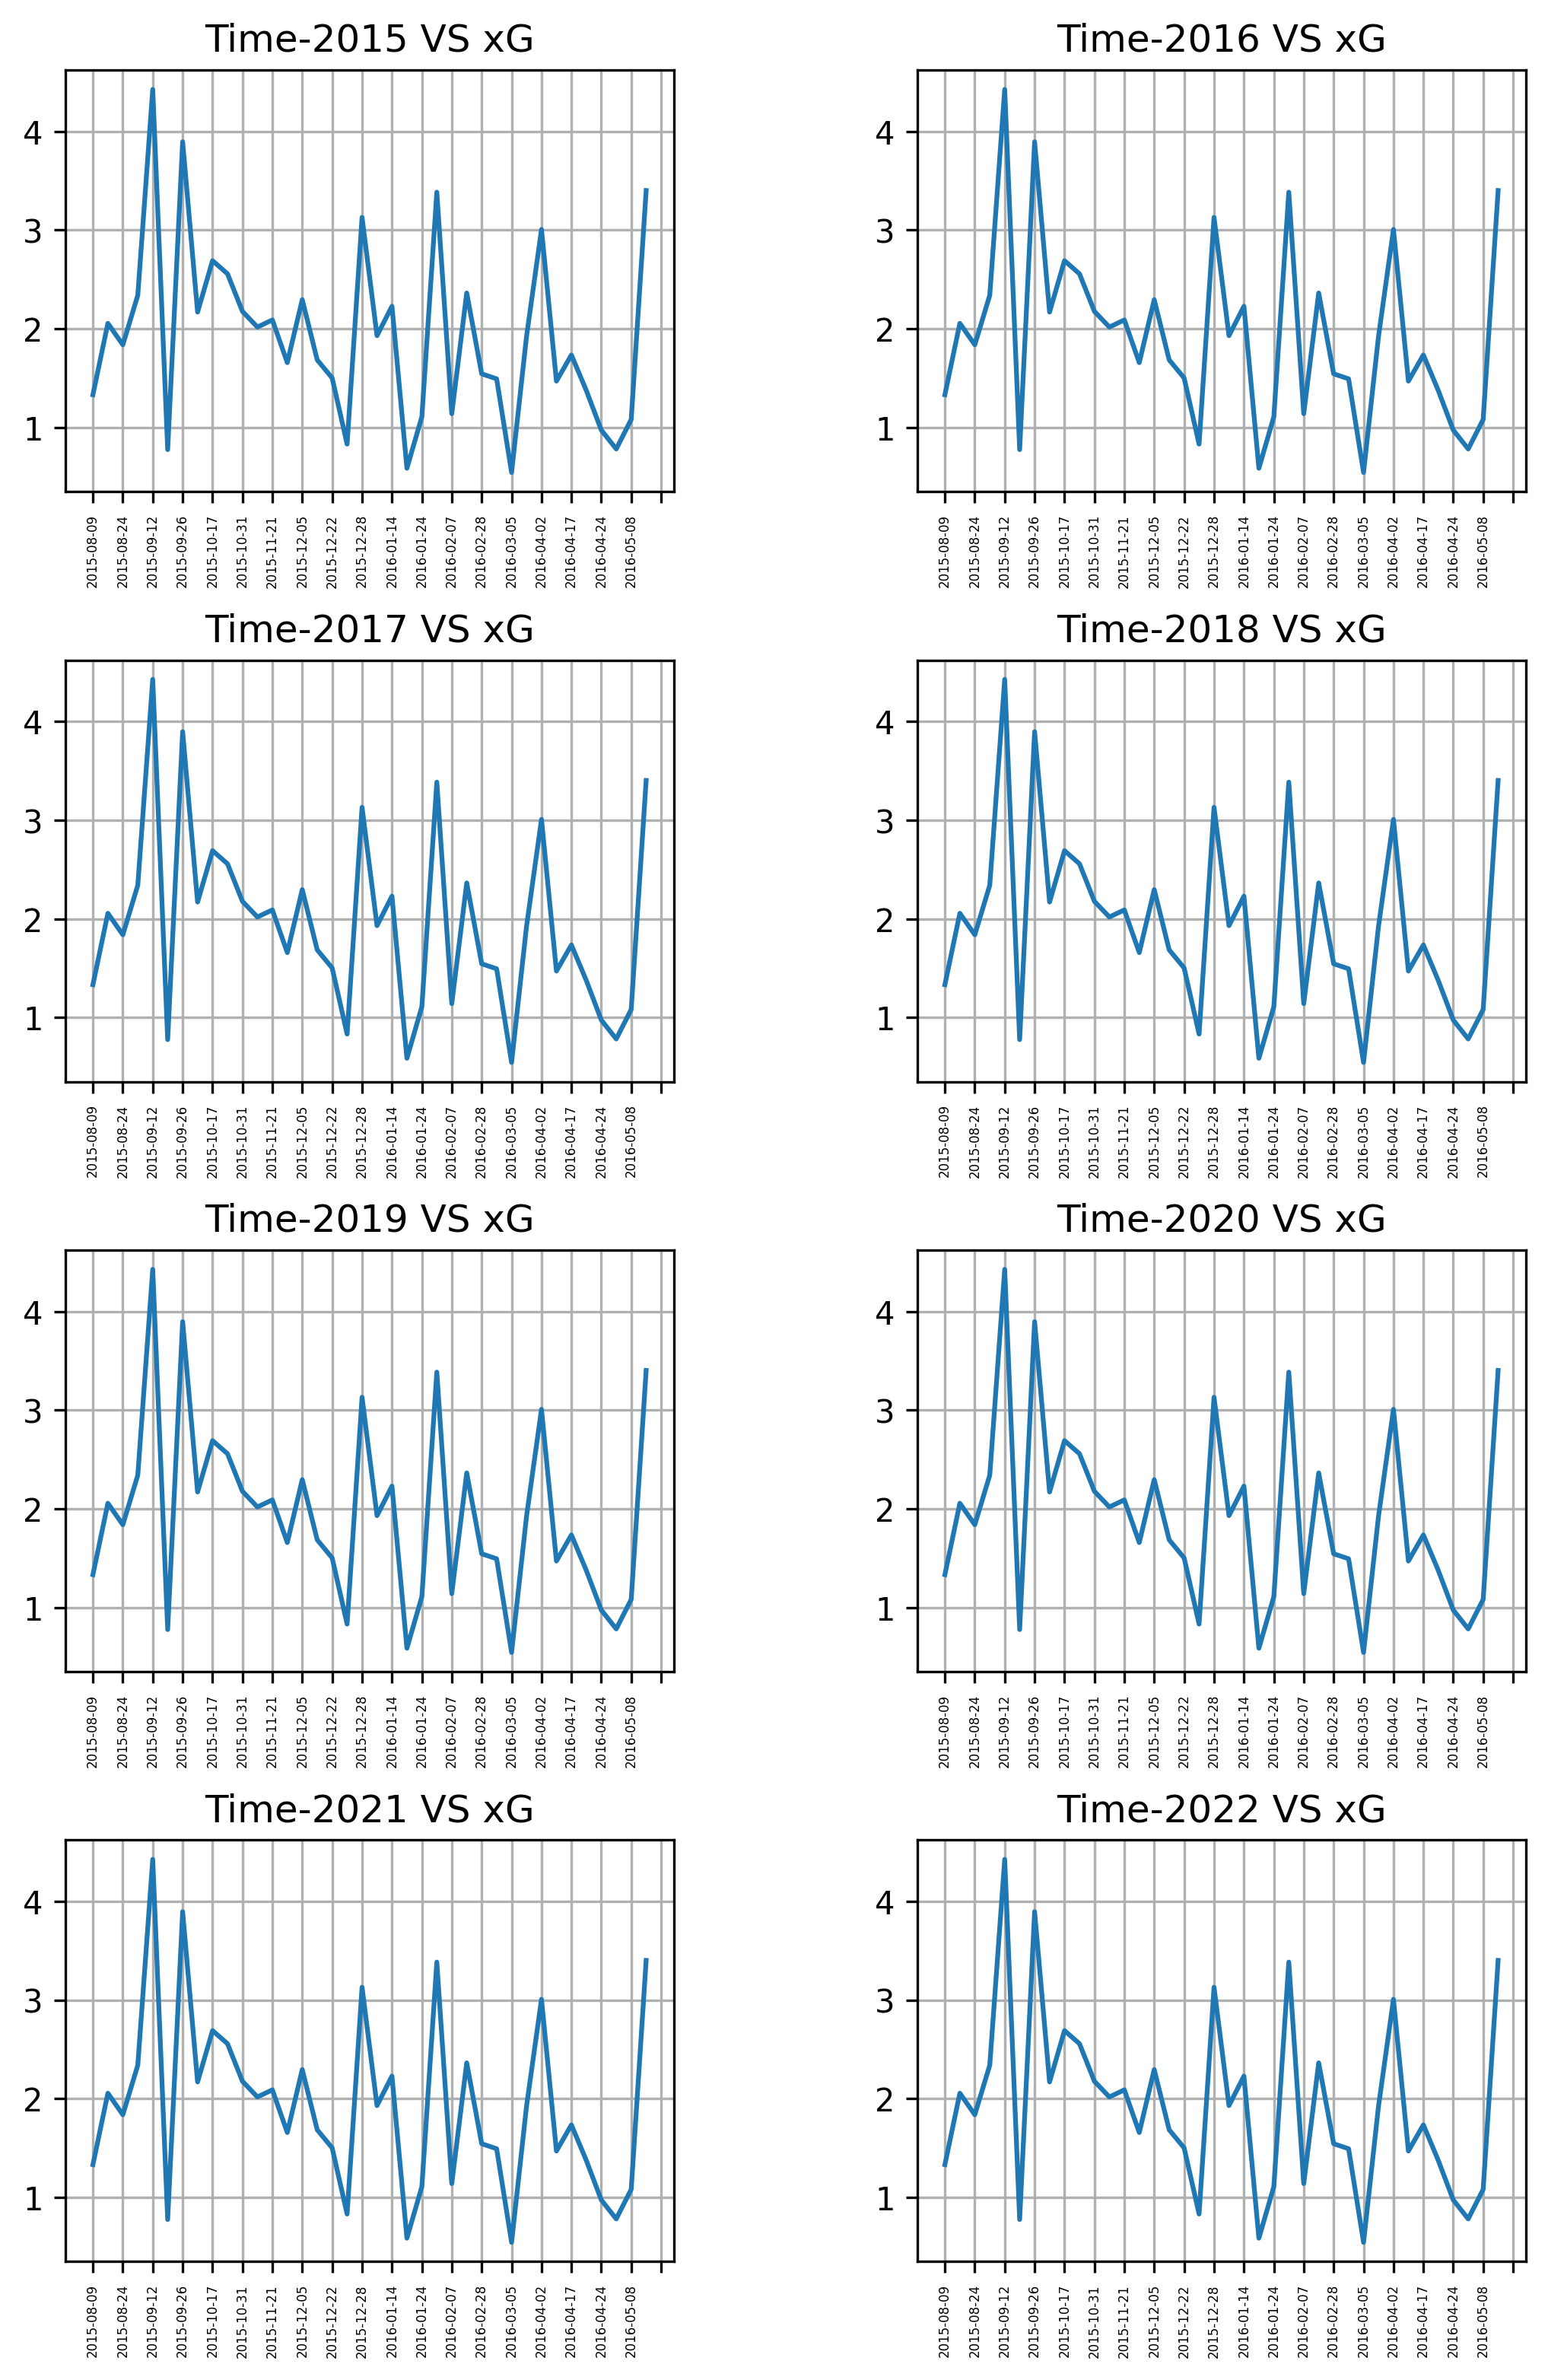

In [313]:
fig, axes = plt.subplots(4,2,figsize=(8,12), dpi = 300)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
for year, ax in zip(range(2015,2023), axes.ravel()):
    data = time_arsenal.loc[time_arsenal['Season'] == str(year)]
    ax.plot('datetime','team_xG', data = d)
    ax.xaxis.set_major_locator(mdates.DayLocator(interval = 2))
    ax.set_title(f'Time-{year} VS xG')
    ax.grid(True)
    for label in ax.get_xticklabels():
        label.set(rotation = 90, fontsize =4)



    